# Iterative Quantum Phase Estimation Algorithm

[ Intro ]

The goal of this tutorial is to understand how the IPE (Iterative Phase Estimation) algorithm works, how to build it and why would we use the IPE algorithm instead of the QPE (Quantum Phase Estimation) algorithm.

**References**

- [Ch.3.5 Quantum Fourier Transform](https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html)
- [Ch.3.6 Quantum Phase Estimation](https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html)


In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, assemble, Aer
from qiskit.tools.visualization import circuit_drawer, plot_histogram
import numpy as np
from math import pi
import matplotlib.pyplot as plt
from qiskit_textbook.tools import array_to_latex

# C_if

The c_if gate, is an method to perform conditioned operations based on the state of the classical register.

For example, the following code will execute the **X** gate if the measurement of the clasical register is **0** but not because the **0** arg is telling the function what does it want to compare, it is because the function c_if expects a quantum register and a value in decimal representation. 

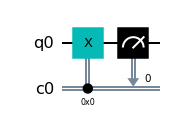

In [2]:
q = QuantumRegister(1)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)
qc.x(q[0]).c_if(c, 0)
qc.measure(q,c)
qc.draw(output='mpl')

So, let's image that we want to perform a bit flip on the first qbit on the following circuit when the measurement of q1 and q2 were both 1

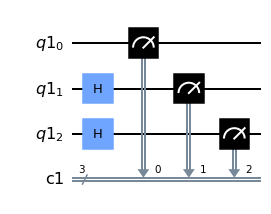

In [3]:
q = QuantumRegister(3)
c = ClassicalRegister(3)
qc = QuantumCircuit(q, c)
qc.h(q[1])
qc.h(q[2])
qc.measure(q,c)
qc.draw(output='mpl')

We will have to encode the c_if so it will check the values 011 or 111 because we do not matter what is in the first position, we want to apply the X gate only if both q1 and q2 were 1


<img src="../../images/binary.png" width="55%" >


We can check our solutions using the bin() method in python

In [4]:
print(bin(3))
print(bin(7))

0b11
0b111


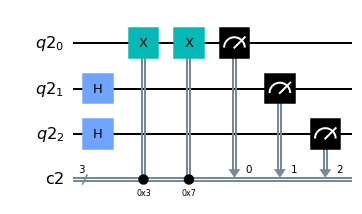

In [5]:
q = QuantumRegister(3)
c = ClassicalRegister(3)
qc = QuantumCircuit(q, c)
qc.h(q[1])
qc.h(q[2])


qc.x(q[0]).c_if(c, 3) # for the 011 case
qc.x(q[0]).c_if(c, 7) # for the 111 case


qc.measure(q,c)
qc.draw(output='mpl')


# IPE

To understand the maths behind the algoritm you can check [Ch.3.5 Quantum Fourier Transform](https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html) and [Ch.3.6 Quantum Phase Estimation](https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html)

The motivation for this tutorial is that QPE algorithm works fine for small circuits but when the circuit starts to grow due to noise and decoherence time it doesn't work properly.

In the [QPE chapter](https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html) a $T$-gate is used and in the [Lab4](https://qiskit.org/textbook/ch-labs/Lab04_IterativePhaseEstimation.html) the same gate is used so we are using a $S$-gate so there are diverse examples.

Let's build the IPE algorithm to stimate the phase of the S-gate:

The explanation of how the algorithm works can be found in [Iterative Phase Estimation (IPE) Algorithm](https://qiskit.org/textbook/ch-labs/Lab04_IterativePhaseEstimation.html#2-iterative-phase-estimation-ipe-algorithm)


The $S$-gate adds a phase of $ e^{\frac{i\pi}{2}} $ to the state $|1\rangle$:


$$ S|1\rangle = 
\begin{bmatrix}
1 & 0\\
0 & e^\frac{i\pi}{2}\\ 
\end{bmatrix}
\begin{bmatrix}
0\\
1\\ 
\end{bmatrix}
= e^\frac{i\pi}{2}|1\rangle $$


So to estimate the phase  $\phi=\frac{\pi}{2}$  for the eigenstate $ T|1\rangle = e^{2i\pi\theta}|1\rangle$ 
 we should find $\varphi=\frac{1}{4}$, since $\phi = 2 \pi \varphi$. Therefore to estimate the phase we neeed exactly 2 classical bits, so with 2 phase qubits we can represent up to 4 values.

First we initialize the circuit, IPE works with 1 counting qubit but we will need 2 phase bits as we have just explained


In [11]:
c_q = 3
q = QuantumRegister(2)
c = ClassicalRegister(c_q)

qc_T = QuantumCircuit(q,c)

Then we initialize the first part of the algorithm  

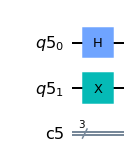

In [12]:
qc_T.h(0)
qc_T.x(1)
qc_T.draw('mpl')

And perform the Cu operations [Summary of Quantum Operations](https://qiskit.org/documentation/tutorials/circuits/3_summary_of_quantum_operations.html#Two-qubit-gates), in this case and because we are using the $S$-gate the $\varphi$ will be $\frac{\pi}{2}$

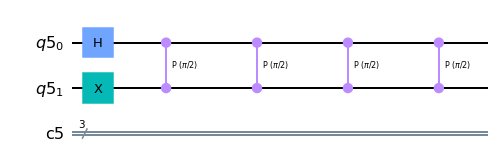

In [13]:
## c-U^(2^t) operations (with t=m-1)
for _ in range(2**(c_q-1)):
    qc_T.cp(np.pi/2,0,1)
qc_T.draw('mpl')

As you can see in the algorithm we need an x_measure, so we are going to define a function to perform the x_measure and then apply it.

In [14]:
def x_measurement(qc, qubit, cbit):
    """Measure 'qubit' in the X-basis, and store the result in 'cbit'"""
    qc.h(qubit)
    qc.measure(qubit, cbit)
    return qc

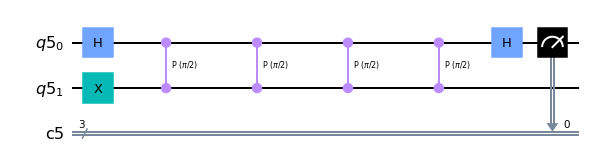

In [15]:
x_measurement(qc_T, q[0], c[0])
qc_T.draw('mpl')

As we want to perform an iterative algorithm in the same circuit we need to reset the auxiliary qubit q0, initialize it again and perform a phase correction, the phase correction is done only if the clasical bit corresponding to the measure of first qubit is 1, so as we saw in the first part of this tutorial, we have to perform the c_if operation with a value of 1 (1 == 001)

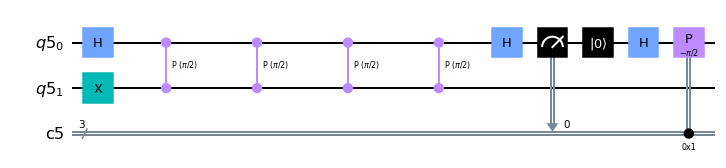

In [16]:
#inizialization of qubit 0
qc_T.reset(0)
qc_T.h(0)

## phase correction
qc_T.p(-np.pi/2,0).c_if(c,1)
qc_T.draw('mpl')

Again the Cu operations and the measurement

In [17]:
## c-U^(2^t) operations (with t=m-2)
for _ in range(2**(c_q-2)):
    qc_T.cp(np.pi/2,0,1)

x_measurement(qc_T, q[0], c[1]) 

Et voilà, we have our final circuit

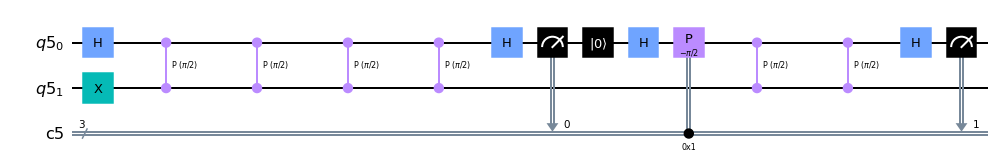

In [18]:
qc_T.draw('mpl')

Let's execute the circuit with the _qasm_simulator_ a fast way to execute circuits becasuse it doesn't need a connection with the real computers.


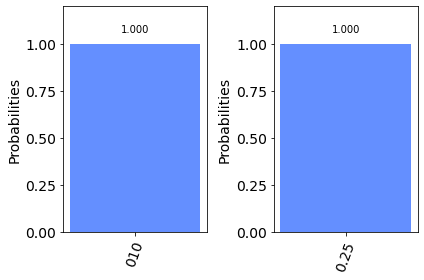

In [19]:
sim = Aer.get_backend('qasm_simulator')
count0 = execute(qc_T, sim).result().get_counts()
n=3
key_new = [str(int(key,2)/2**n) for key in list(count0.keys())]
count1 = dict(zip(key_new, count0.values()))

fig, ax = plt.subplots(1,2)
plot_histogram(count0, ax=ax[0])
plot_histogram(count1, ax=ax[1])
plt.tight_layout()

In the printend plots we have on the left histogram the bit representation and on the right the phase value in decimal representation.

As we explained before, we expect to get $\varphi=\frac{1}{4}$ which is 0.25 with a $100\%$ probability!!!


## IPE example with a 2-qubit gate

In the following, we will use, the notation and terms used in [Section 2 of lab 4](https://qiskit.org/textbook/ch-labs/Lab04_IterativePhaseEstimation.html#2-iterative-phase-estimation-ipe-algorithm), where is explained the IPE algorithm.

We want to apply the IPE algorithm to estimate the phase for a 2-qubit gate $U$. For this example, let's consider the controlled version of the $T$ gate, i.e. the gate $U=\textrm{Controlled-}T$ (that from now we will express more complactly with $CT$). Its matrix is
$$ CT = 
\begin{bmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & e^\frac{i\pi}{4}\\ 
\end{bmatrix} $$
That is, the $CT$ gate adds a phase $\pi/4$ to the state $|11\rangle$, leaving unchanged the phase of the other computational basis states $|00\rangle$, $|01\rangle$, $|10\rangle$.

Let's consider to estimate the phase $\phi=\pi/4$ for the eigenstate $|11\rangle$, we should find $\varphi=1/8$, since $\phi = 2 \pi \varphi$. Therefore to estimate the phase we neeed exactly 3 classical bits, i.e. $m=3$, since $1/2^3=1/8$. So $\varphi=0.\varphi_1\varphi_2\varphi_3$.

Remember from the theory that for the IPE algorithm $m$ is also the number of iterations, so we need $3$ iterations or steps.

First, we initialize the circuit with 3 qbuits, 1 for the auxiliary qubit and 2 for the 2-qubit gate, and 3 classical bits to store the estimated phase $\varphi$.

In [16]:
nq = 3    # number of qubits
m = 3    # number of classical bits
q = QuantumRegister(nq,'q')
c = ClassicalRegister(m,'c')

qc = QuantumCircuit(q,c)

### First step

Now we build the quntum circuit for the first step, that is, the first iteration of the algorithm, to estimate the least significant phase bit $\varphi_3$. For the first step we have 3 sub-steps:
- initialization
- application of the Control-$U$ gates
- measure of the auxiliary qubit in x-basis

#### Initialization

The initialization consists of application the Hadamard gate to the counting qubit and the preparation of the eigenvector $|11\rangle$

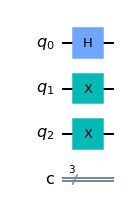

In [17]:
qc.h(0)
qc.x([1,2])
qc.draw('mpl')

#### Application of the Controlled-$U$ gates

Then we have to apply $2^t$ times the Controlled-$U$ operators, that, in this example, is the Controlled-$CT$ gate ($CCT$ for short).

To implement $CCT$ in the circuit, since $T$ is a phase gate, we can use the multi-controlled phase gate $\text{MCP}(\theta)$, with $\theta=\pi/4$.

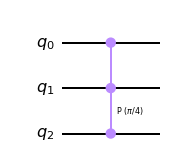

In [18]:
cu_circ = QuantumCircuit(nq)
cu_circ.mcp(pi/4,[0,1],2)
cu_circ.draw('mpl')

Let's apply $2^t$ times $\text{MCP}(\pi/4)$. Since for the first step $t=m-1$ and $m=3$, we have $2^t=4$.

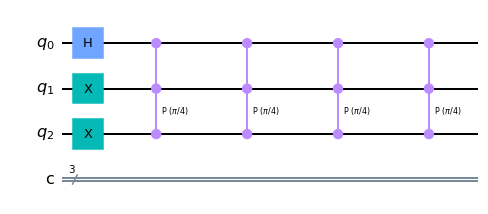

In [19]:
for _ in range(2**(m-1)):
    qc.mcp(pi/4,[0,1],2)
qc.draw('mpl')

#### Measure in x-basis

Finally, we perform the measurenment of the auxiliary qubit in x-basis.
We can use the `x_measurement` function defined above in the example for 1-qubit gate. In this way we have obtained the phase bit $\varphi_3$ and stored it in the classical bit $c_0$.

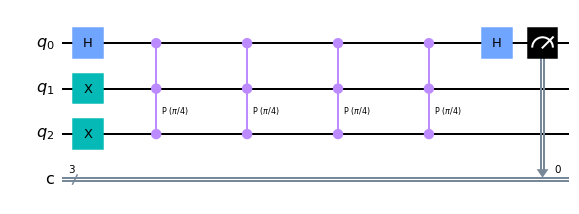

In [20]:
x_measurement(qc, q[0], c[0])
qc.draw('mpl')

### Subsequent steps (2nd, 3rd...)

Now we build the quntum circuit for the other remaining steps, the second and the third ones.
In these steps we have 4 sub-steps, the 3 sub-steps as in the first step and, in the middle, the additional step of the phase correction
- initialization with reset
- phase correction
- application of the Control-$U$ gates
- measure of the auxiliary qubit in x-basis

#### Initialization with reset

As we want to perform an iterative algorithm in the same circuit, we need to reset the auxiliary qubit after the measument gate and initialize the auxiliary qubit again as before. There is no need to reset and initialize again even the 2 qubits of the eigeinstate, as their states are not changed because they are not affected by $CU$ operations and are not measured.

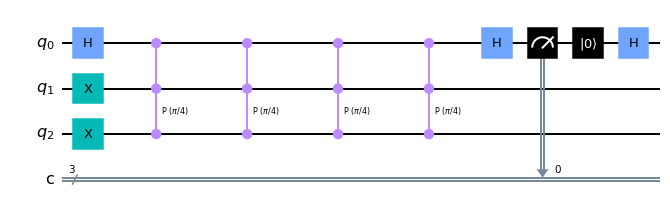

In [21]:
qc.reset(0)
qc.h(0)
qc.draw('mpl')

#### Phase correction (for step 2)
As seen in the theory, in order to extract the phase bit $\varphi_{2}$, we perform a phase correction of $-\pi\varphi_3/2$.
Of course, we need to apply the phase correction in the circuit only if the phase bit $\varphi_3=1$, i.e. we have to apply the phase correction of $-\pi/2$ only if the classical bit $c_0$ is 1.

So, after the reset we apply the phase gate $P(\theta)$ with phase $\theta=-\pi/2$ conditioned by the classical bit $c_0$ ($=\varphi_3$) using the `c_if` function.
So as we saw in the first part of this tutorial, we have to use the `c_if` function with a value of 1, as $1_{10} = 001_{2}$ (the subscripts $_{10}$ and $_2$ indicate the decimal and binary representations).

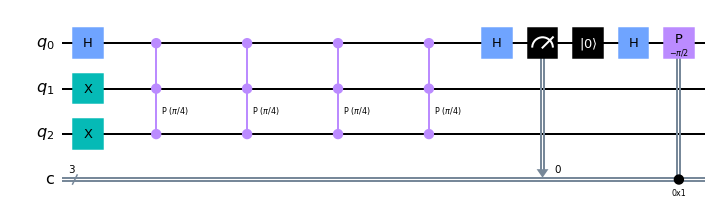

In [22]:
qc.p(-pi/2,0).c_if(c,1)
qc.draw('mpl')

#### Application of the Control-$U$ gates and x-measurement (for step 2)
We apply the $C-U^{2^t}$ operations as we did in the first step. For the second step we have $t=m-2$, hence $2^t=2$. So we apply $\text{MCP}(\pi/4)$ $2$ times. And then we perform the x-measurment of the qubit $q_0$, storing the result, the phase bit $\varphi_2$, in the bit $c_1$ of classical register.

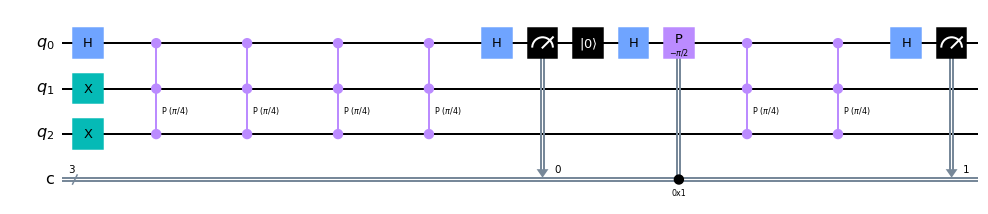

In [23]:
for _ in range(2**(m-2)):
    qc.mcp(pi/4,[0,1],2)
x_measurement(qc, q[0], c[1])
qc.draw('mpl')

#### All substeps of the 3rd step
For the 3rd and last step, we perform the reset and initialization of the auxiliary qubit as done in the second step.

Then at the 3rd step we have to perform the phase correction of $-2\pi 0.0\varphi_{2}\varphi_{3}= -2\pi \left(\frac{\varphi_2}{4}+\frac{\varphi_3}{8}\right)=-\frac{\varphi_2\pi}{2}-\frac{ \varphi_3\pi}{4}$, thus we have to apply 2 conditioned  phase corrections, one conditioned by $\varphi_3$ ($=c_0$) and the other by $\varphi_2$($=c_1$). To do this we have to apply the following:
- gate $P(-\pi/4)$ conditioned by $c_0=1$, that is, by $c=001$ (c_if with vaule 1)
- gate $P(-\pi/2)$ conditioned by $c_1=1$, that is, the gate is applied when $c=011$ or $c=010$ (c_if with values $3$ and $2$)

Next, the $CU$ operations: we apply $2^t$ times the $\text{MCP}(\pi/4)$ gate and since at the 3rd step $t=m-3=0$, we apply the gate only once.

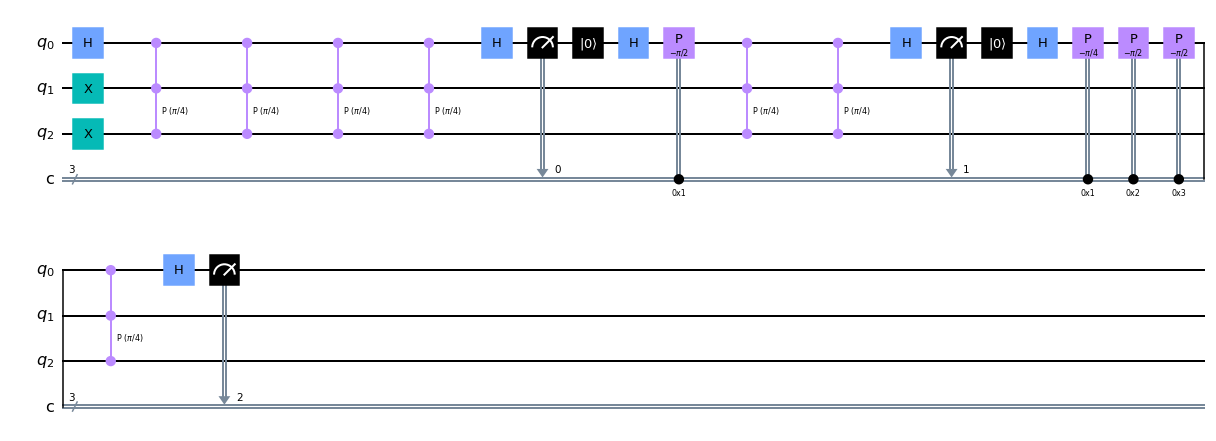

In [24]:
# initialization of qubit q0
qc.reset(0)
qc.h(0)

# phase correction
qc.p(-pi/4,0).c_if(c,1)

qc.p(-pi/2,0).c_if(c,2)
qc.p(-pi/2,0).c_if(c,3)

# c-U operations
for _ in range(2**(m-3)):
    qc.mcp(pi/4,[0,1],2)

# X measurement  
qc.h(0)
qc.measure(0,2)

qc.draw('mpl')

Now, we execute the circuit with the simulator without noise. In the below plot picture, the left histogram is with bit strings and the right one is with the actual phase values in decimal representation.

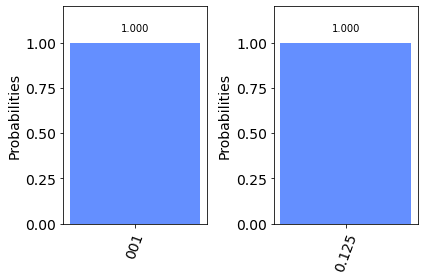

In [25]:
count0 = execute(qc, sim).result().get_counts()

key_new = [str(int(key,2)/2**m) for key in list(count0.keys())]
count1 = dict(zip(key_new, count0.values()))

fig, ax = plt.subplots(1,2)
plot_histogram(count0, ax=ax[0])
plot_histogram(count1, ax=ax[1])
plt.tight_layout()

We have obtained $100\%$ probability to find $\varphi=0.125$, that is, $1/8$, as expected.

## Example of IPE using the IPE qiskit function
[TO BE DONE]

In [26]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright